In [51]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import VOCDetection
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader


In [52]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, year="2007", image_set="train", transforms=None):
        self.dataset = VOCDetection(root, year=year, image_set=image_set, download=False)
        self.transforms = transforms


    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        img = F.to_tensor(img)


        boxes = []
        labels = []
        for obj in target['annotation']['object']:
            bbox = obj['bndbox']
            boxes.append([
            float(bbox['xmin']),
            float(bbox['ymin']),
            float(bbox['xmax']),
            float(bbox['ymax'])
        ])
            labels.append(1) # single-class example


        target = {
        "boxes": torch.tensor(boxes, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.int64)
        }


        return img, target


    def __len__(self):
        return len(self.dataset)

In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))


train_dataset = VOCDataset("./data", image_set="train")
val_dataset = VOCDataset("./data", image_set="val")

from torch.utils.data import Subset
train_dataset = Subset(train_dataset, range(100))
val_dataset = Subset(val_dataset, range(50))


train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_classes = 21  # 20 VOC classes + background

# Φτιάχνουμε το pretrained μοντέλο
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Αντικαθιστούμε το box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes
)

# Στέλνουμε όλο το μοντέλο στο σωστό device
model = model.to(device)

cpu


In [ ]:
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005
)


num_epochs = 5

from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    # tqdm wrapper για τον train_loader
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.2f}")


In [ ]:
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005
)


num_epochs = 5

from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    # tqdm wrapper για τον train_loader
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.2f}")


In [18]:
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005
)

train_losses = []
val_losses = []

num_epochs = 5

from tqdm import tqdm

for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    epoch_loss = 0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    epoch_loss /= len(train_loader)  # υπολογισμένο σωστά

    # ---- VALIDATION ----
    model.train()  # για να δίνει loss
    val_loss = 0

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    val_loss /= len(val_loader)

    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={epoch_loss:.4f}, "
        f"Val Loss={val_loss:.4f}"
    )

    train_losses.append(epoch_loss)
    val_losses.append(val_loss)


Epoch 1/5: 100%|██████████| 100/100 [14:36<00:00,  8.76s/it]


Epoch 1: Train Loss=0.1580, Val Loss=0.3976


Epoch 2/5: 100%|██████████| 100/100 [12:28<00:00,  7.49s/it]


Epoch 2: Train Loss=0.1571, Val Loss=0.3905


Epoch 3/5: 100%|██████████| 100/100 [12:15<00:00,  7.35s/it]


Epoch 3: Train Loss=0.1409, Val Loss=0.4078


Epoch 4/5: 100%|██████████| 100/100 [12:07<00:00,  7.28s/it]


Epoch 4: Train Loss=0.1229, Val Loss=0.4190


Epoch 5/5: 100%|██████████| 100/100 [09:12<00:00,  5.53s/it]


Epoch 5: Train Loss=0.1179, Val Loss=0.4200


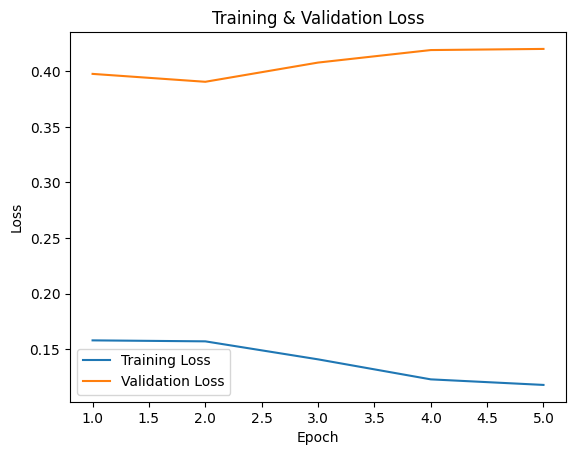

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses)+1)

plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()
